In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

def dendrogram_tune(*args, **kwargs):
    
    max_d=kwargs.pop("max_d", None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    
    ddata = dendrogram(*args,**kwargs)
        
    if not kwargs.get('no_plot', False):
        plt.title("Clustering jerárquico con Dendrograma truncado")
        plt.xlabel("Índice del Dataset (o tamaño del cluster)")
        plt.ylabel("Distancia")
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y>annotate_above:
                plt.plot(x,y,'o',c=c)
                plt.annotate('%.3g'%y, (x,y), xytext=(0,-5),
                            textcoords="offset points", va="top", ha="center")
                
    if max_d:
        plt.axhline(y=max_d, c='k')
        
    return ddata



# Preprocesamiento para clustering

In [12]:
data = pd.read_excel("datos_procesados.xlsx")
data.head()

,X,Y,OBJECTID,RADICADO,FECHA,MES,ANIO,HORA,DIA,PERIODO,...,DIA_NOMBRE,MES2,MES_NOMBRE,X_MAGNAMED,Y_MAGNAMED,LONGITUD,LATITUD,SHAPE,AUX_B,AUX_C
0,-7.560273e+14,6.219016e+15,2112790,1423828.0,2013-12-31 19:00:00,12,2013,02:20:00,10,20140,...,miercoles,10,NaN,83119008,11796895,-7560272578,621901553,NaN,belen,NaN
1,-7.556818e+14,6.260009e+14,2112800,1423839.0,2013-12-31 19:00:00,12,2013,12:50:00,10,20140,...,miercoles,10,NaN,83501363,118422379,-7556818471,6260008999999998,NaN,la candelaria,NaN
2,-7.554994e+14,6.264765e+14,2112810,1423840.0,2013-12-31 19:00:00,12,2013,01:00:00,10,20140,...,miercoles,10,NaN,83703271,118474986,-7554994311,626476471,NaN,NaN,NaN
3,-7.560761e+14,6.234327e+14,2112820,1423849.0,2013-12-31 19:00:00,12,2013,12:37:00,10,20140,...,miercoles,10,NaN,83064947,118138324,-756076108,623432737,NaN,belen,NaN
4,-7.557969e+14,6.299968e+14,2112830,1423890.0,2013-12-31 19:00:00,12,2013,10:40:00,10,20140,...,miercoles,10,NaN,83374078,11886438,-7557968545,629996777,NaN,NaN,NaN


Solo se trabajaran con los atributos:

- Barrio
- Mes 
- Anio
- Clase
- Gravedad

In [13]:
data = data[["BARRIO","ANIO","MES","CLASE","GRAVEDAD"]]

## Agrupar datos por barrios

Se agruparan los datos por barrio y se sacaran las siguientes metricas:

- Promedio mensual de accidente
- promedio mensual de accidentes atropello
- Promedio mensual de accidentes 
- Promedio mensual de accidentes 
- Promedio mensual de accidentes 
- Promedio mensual de accidentes 
- Promedio mensual de accidentes 
- Promedio mensual de accidentes 
- Promedio mensual de accidentes con gravedad herido
- Promedio mensual ed accidentes con gravedad Muerto
- Promeido mensual de accidentes con gravedad solo daños


Se agrupa y se genera un resultado acumulado por barrio, mes y año 

Primero se obtienen el Promedio mensual de accidentes total

In [18]:
men_acc = data.groupby(["BARRIO","ANIO","MES"]).count()
men_acc.head()

CLASE  GRAVEDAD
BARRIO      ANIO MES                 
aguas frias 2014 1        1         1
                 2        3         3
                 3        1         1
                 4        3         3
                 5        4         4

Se promedian los resultados

In [19]:
men_acc = men_acc.groupby(["BARRIO"]).mean()
men_acc.to_excel("prom_men_acc.xlsx")

Se haya el promedio mensual de accidentes por gravedad

In [31]:
pd.unique(data["GRAVEDAD"])

array(['herido', 'solo daÃ±os', 'muerto'], dtype=object)

In [32]:
for gravedad in pd.unique(data["GRAVEDAD"]):
    men_acc_grav = data[data['GRAVEDAD'] == gravedad].groupby(["BARRIO","ANIO","MES","GRAVEDAD"]).count()
    men_acc_grav = men_acc_grav.groupby(["BARRIO","GRAVEDAD"]).mean()
    men_acc_grav.to_excel("prom_men_acc_grav_"+gravedad+".xlsx")

In [28]:
men_acc_grav = data[data['GRAVEDAD'] == 'herido'].groupby(["BARRIO","ANIO","MES","GRAVEDAD"]).count()
men_acc_grav.head()

CLASE
BARRIO      ANIO MES GRAVEDAD       
aguas frias 2014 1   herido        1
                 2   herido        2
                 3   herido        1
                 4   herido        2
                 5   herido        4

In [29]:
men_acc_grav = men_acc_grav.groupby(["BARRIO","GRAVEDAD"]).mean()
men_acc_grav.to_excel("prom_men_acc_grav_herido.xlsx")

In [30]:
men_acc_grav.head()

,,CLASE
BARRIO,GRAVEDAD,
aguas frias,herido,1.690476
aldea pablo vi,herido,1.500000
alejandria,herido,2.656250
alejandro echavarria,herido,9.944444
alfonso lopez,herido,12.263889


# Lectura de Datos

In [97]:
data = pd.read_excel("data_barrio.xlsx")
data.head()

,BARRIO,ACCIDENTES,MUERTO,HERIDO,SOLO_DANOS
0,aguas frias,1.959184,0.000000,1.690476,1.136364
1,aldea pablo vi,1.803571,1.000000,1.500000,1.166667
2,alejandria,8.366197,1.000000,2.656250,5.957746
3,alejandro echavarria,13.958904,1.000000,9.944444,4.095890
4,alfonso lopez,18.208333,1.166667,12.263889,5.929577


Normalizacion de datos

In [98]:
X_index = ["ACCIDENTES","MUERTO","HERIDO","SOLO_DANOS"]
min_max_scalers = {}
for index in X_index:
    x = data[index].values
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(x.reshape(-1,1))
    min_max_scalers[index] = min_max_scaler
    x_scaled = min_max_scaler.transform(x.reshape(-1,1))
    data[index] = x_scaled

    
data.head()

,BARRIO,ACCIDENTES,MUERTO,HERIDO,SOLO_DANOS
0,aguas frias,0.011449,0.000000,0.045774,0.022944
1,aldea pablo vi,0.009591,0.500000,0.040617,0.023556
2,alejandria,0.087922,0.500000,0.071926,0.120291
3,alejandro echavarria,0.154676,0.500000,0.269274,0.082699
4,alfonso lopez,0.205397,0.583333,0.332080,0.119722


## Dendogramas

Un dendrograma es un tipo de representación gráfica en forma de árbol que organiza y agrupa los datos en subcategorías según su similitud; dada por alguna medida de distancia. Los objetos similares se representan en el dendrograma por medio de un enlace cuya posición está determinada por el nivel de similitud entre los objetos o grupos de objetos. Dadas estas características, hace que los dendrogramas sean un tipo de diagrama muy útil para estudiar las agrupaciones de objetos; es decir, para estudiar los Clusters que pueden darse en un data set.

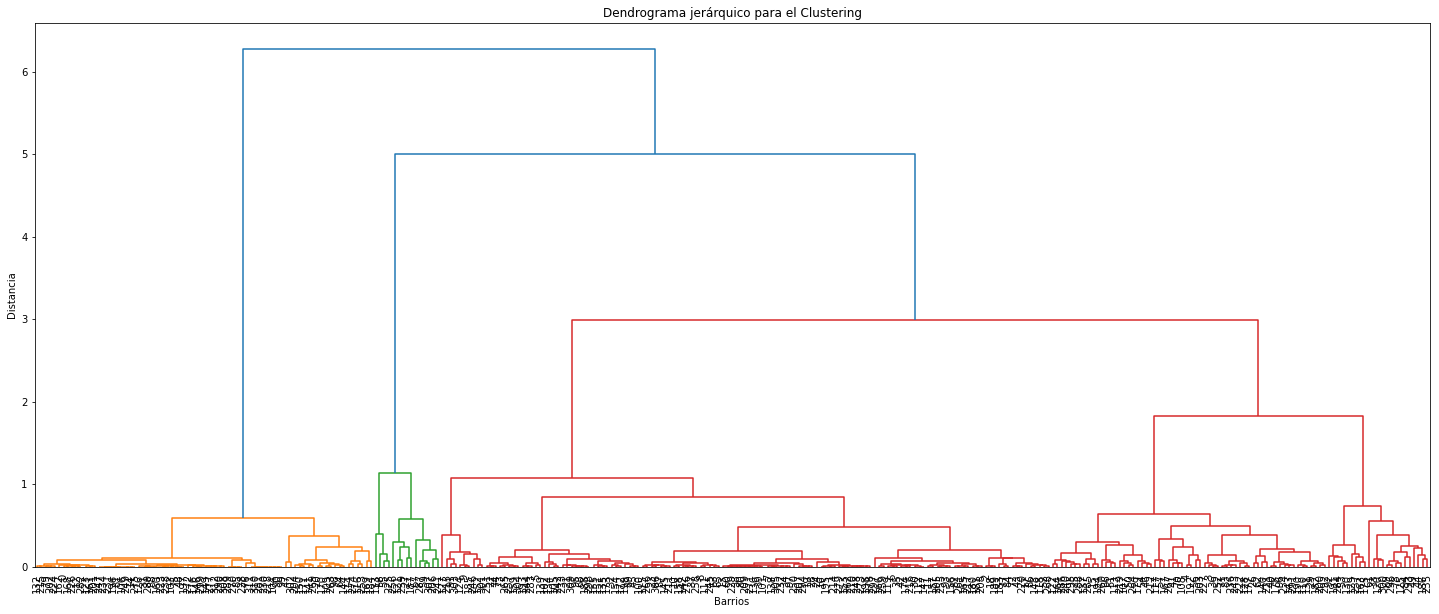

In [77]:
Z = linkage(data[X_index], "ward", metric = "euclidean")
Z
plt.figure(figsize=(25,10))
plt.title("Dendrograma jerárquico para el Clustering")
plt.xlabel("Barrios")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90., leaf_font_size=10.0)
plt.show()

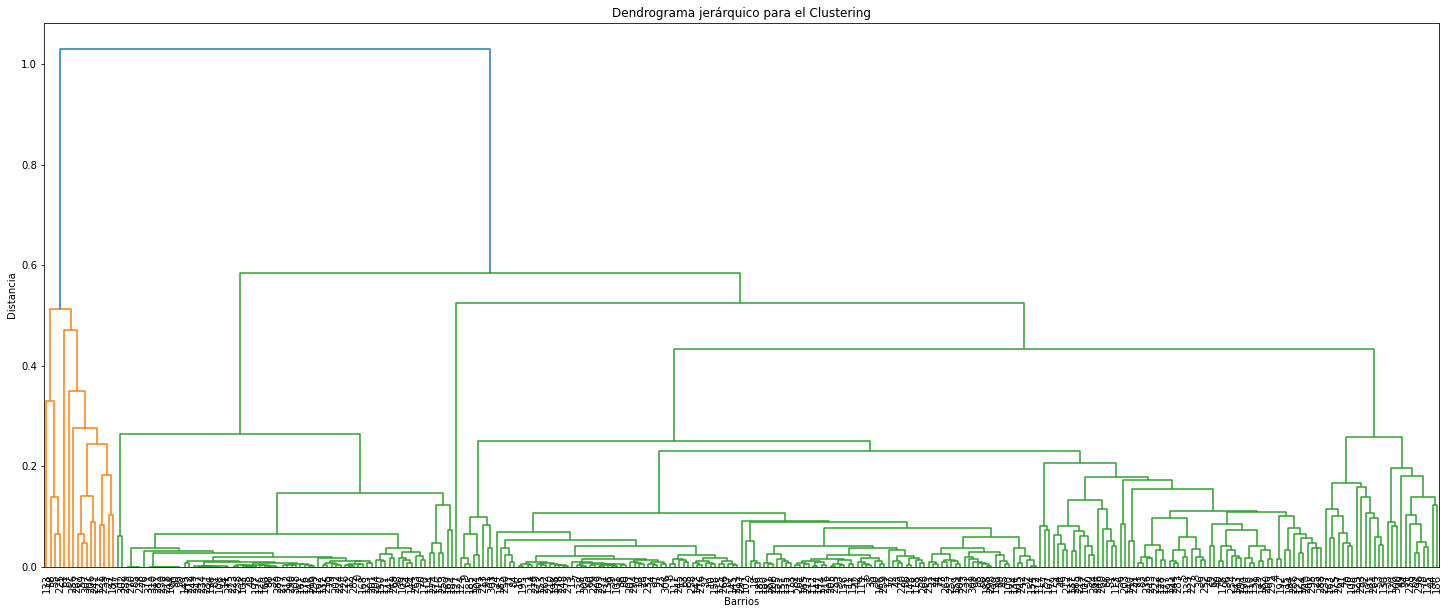

In [17]:
Z = linkage(data[X_index], "average")
Z
plt.figure(figsize=(25,10))
plt.title("Dendrograma jerárquico para el Clustering")
plt.xlabel("Barrios")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90., leaf_font_size=10.0)
plt.show()

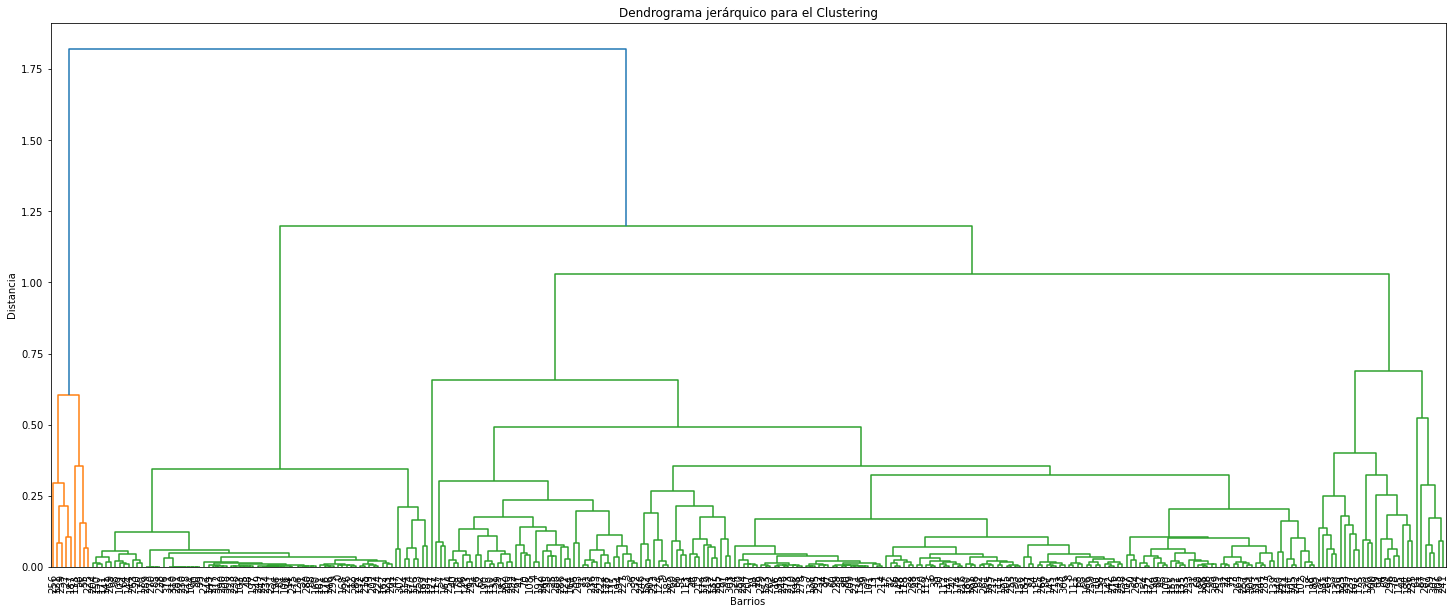

In [18]:
Z = linkage(data[X_index], "complete")
Z
plt.figure(figsize=(25,10))
plt.title("Dendrograma jerárquico para el Clustering")
plt.xlabel("Barrios")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90., leaf_font_size=10.0)
plt.show()

The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.


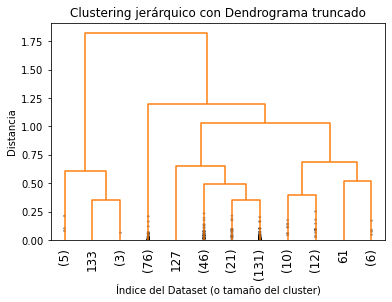

In [20]:
Z = linkage(data[X_index], "complete")
dendrogram_tune(Z,truncate_mode='lastp',p=12, leaf_rotation=90., leaf_font_size=12.,
                show_contracted=True,annotate_above=10, max_d=20)
plt.show()

La idea básica de los algoritmos de clustering es la minimización de la varianza intra-cluster y la maximización de la varianza inter-cluster.

# Método del Codo

Este metodo utiliza los valores de inercia la cual es una distancia media de las observaciones a su centroide. Es decir, se fija en las distancias intra-cluster. Cuanto más grande es el número de clusters k, la varianza intra-cluster tiende a disminuir. Cuanto menor es la distancia intra-cluster mejor, ya que significa que los clústers son más compactos. El método del codo busca el valor k que satisfaga que un incremento de k, no mejore sustancialmente la distancia media intra-cluster.

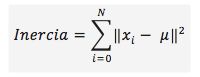

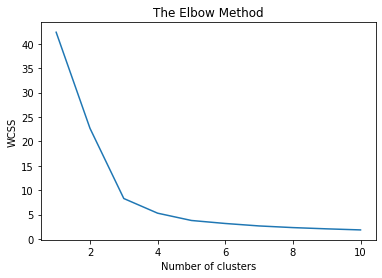

In [78]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data[X_index])
    wcss.append(kmeans.inertia_)

# Grafica de la suma de las distancias
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

[6.27490888 4.99943813 2.98955178 1.8202681  1.14078971 1.07515852
 0.84943344 0.73558367 0.6336245  0.59384069]


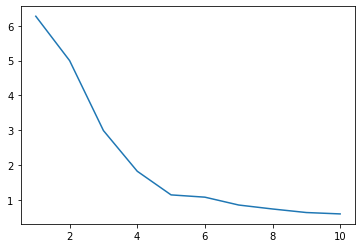

El número óptimo de cluster es 3


In [79]:
last = Z[-10:,2]
last_rev = last[::-1]
print(last_rev)
idx = np.arange(1, len(last)+1)
plt.plot(idx, last_rev)

acc = np.diff(last,2)
acc_rev = acc[::-1]
#plt.plot(idx[:-2]+1, acc_rev)
plt.show()
k = acc_rev.argmax() + 2
print("El número óptimo de cluster es %s"%str(k))

# Método de la silueta

El valor de la silueta es una medida de cuán similar es un objeto a su propio cúmulo (cohesión) en comparación con otros cúmulos (separación). La silueta va de ˜1 a +1, donde un valor alto indica que el objeto está bien emparejado con su propio cúmulo y mal emparejado con los cúmulos vecinos. Si la mayoría de los objetos tienen un valor alto, entonces la configuración del cúmulo es apropiada. Si muchos puntos tienen un valor bajo o negativo, entonces la configuración de cúmulos puede tener demasiados o muy pocos cúmulos.

En otras palabras Los coeficientes de silueta cercanos a +1 indican que la observación se encuentra lejos de los clústers vecinos. Un valor del coeficiente de 0 indica que la observación está muy cerca o en la frontera de decisión entre dos clústers. Valores negativos indican que esas muestras quizás estén asignadas al clúster erróneo.
$$
S = \frac{b-a}{max(a,b)}
$$

* Para k =  2  el promedio de la silueta es de : 0.6135475947943206
   - Para i =  1  la silueta del cluster vale :  0.5214650664860401
   - Para i =  2  la silueta del cluster vale :  0.9006996896504064
* Para k =  3  el promedio de la silueta es de : 0.6973305508170788
   - Para i =  1  la silueta del cluster vale :  0.8900877658494571
   - Para i =  2  la silueta del cluster vale :  0.6657664017492311
   - Para i =  3  la silueta del cluster vale :  0.4268049013032052
* Para k =  4  el promedio de la silueta es de : 0.6029881986769978
   - Para i =  1  la silueta del cluster vale :  0.30242662232536316
   - Para i =  2  la silueta del cluster vale :  0.8854860348392816
   - Para i =  3  la silueta del cluster vale :  0.46007444093205113
   - Para i =  4  la silueta del cluster vale :  0.6184215560883843
* Para k =  5  el promedio de la silueta es de : 0.5834740727164265
   - Para i =  1  la silueta del cluster vale :  0.5792222541758998
   - Para i =  2  la silueta del cluster vale 

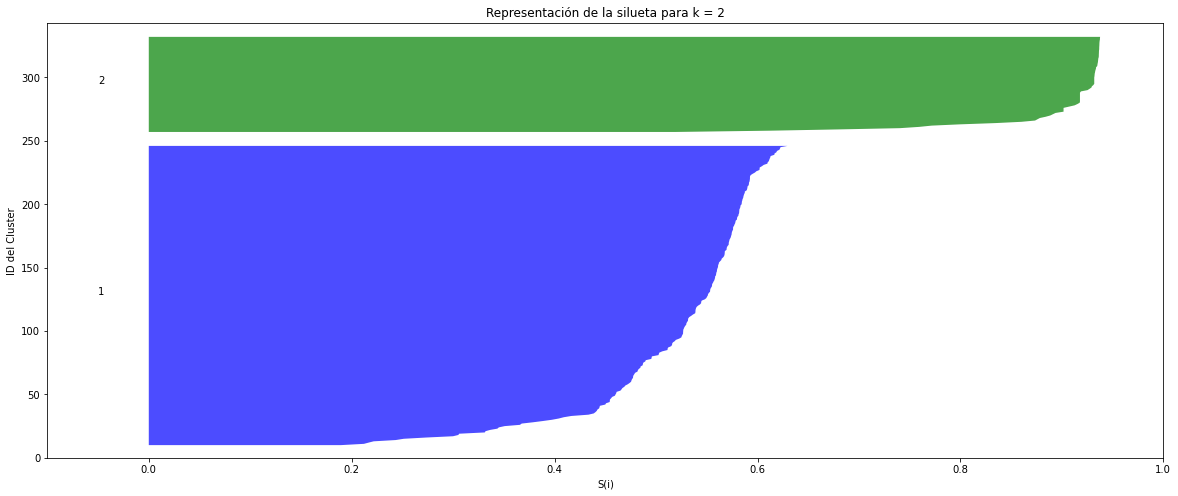

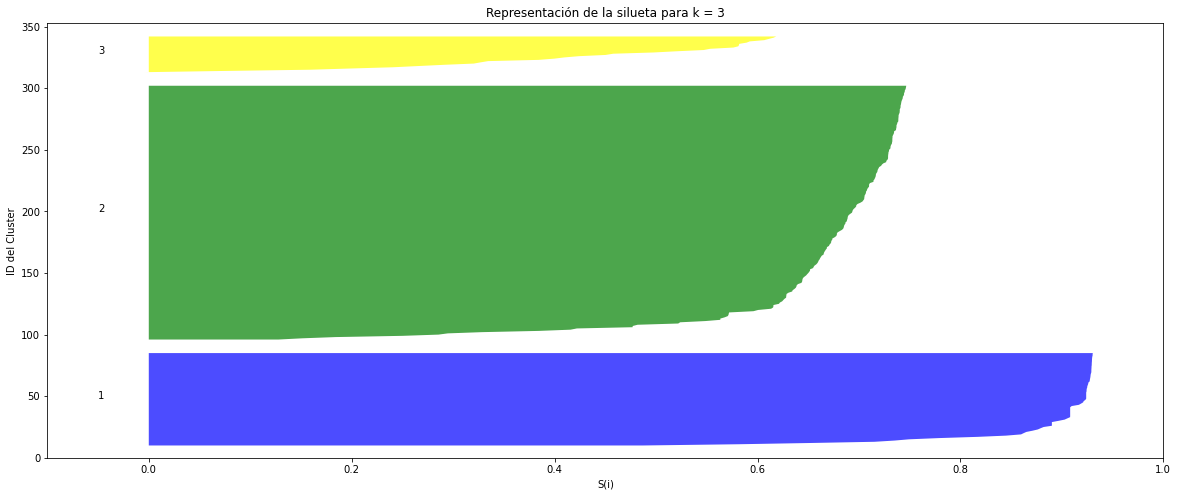

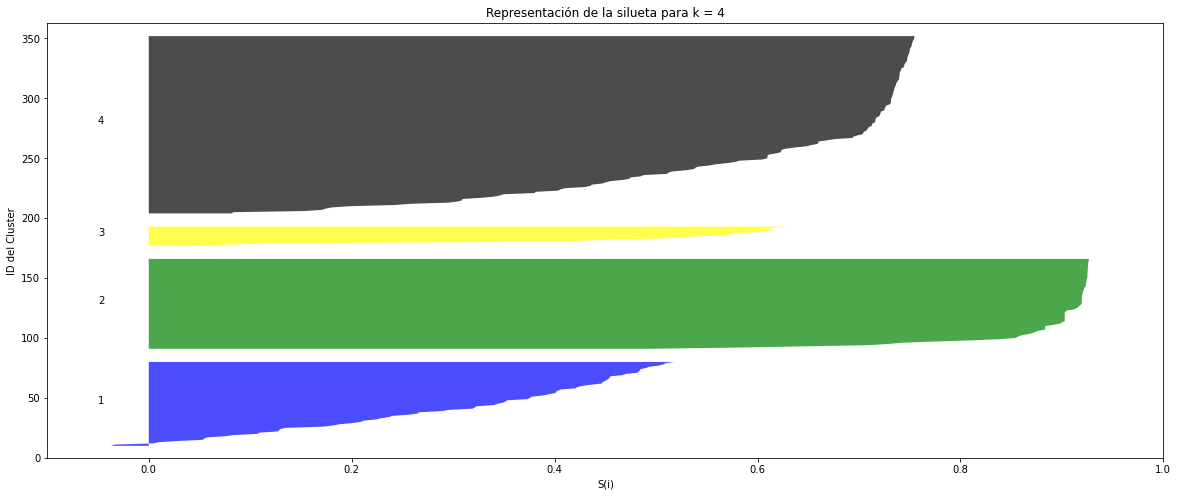

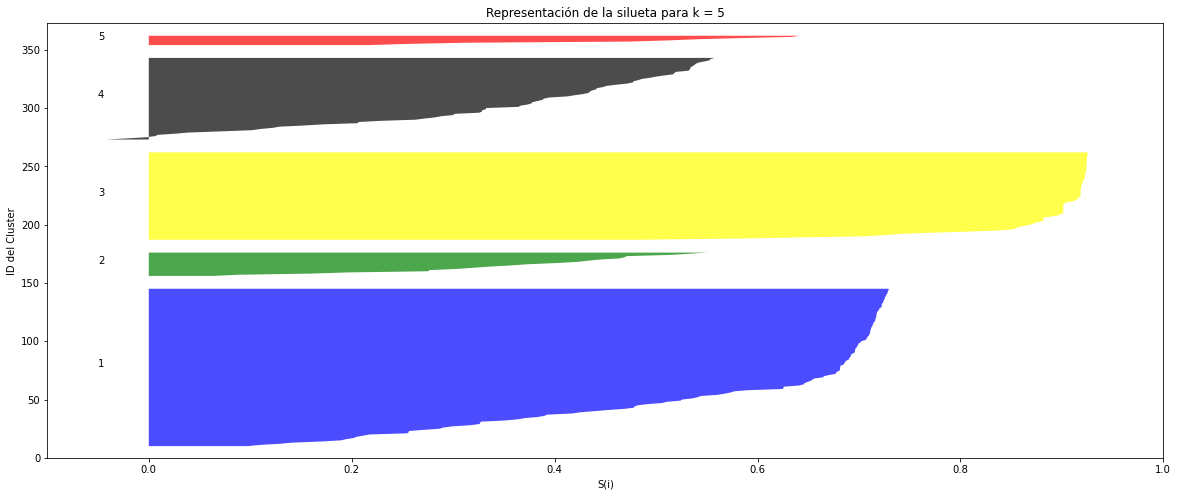

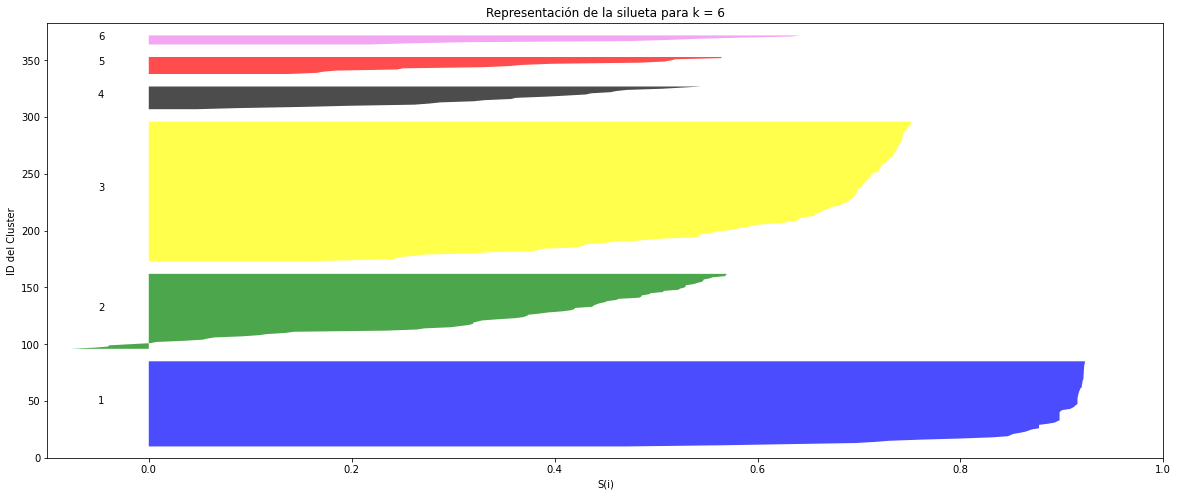

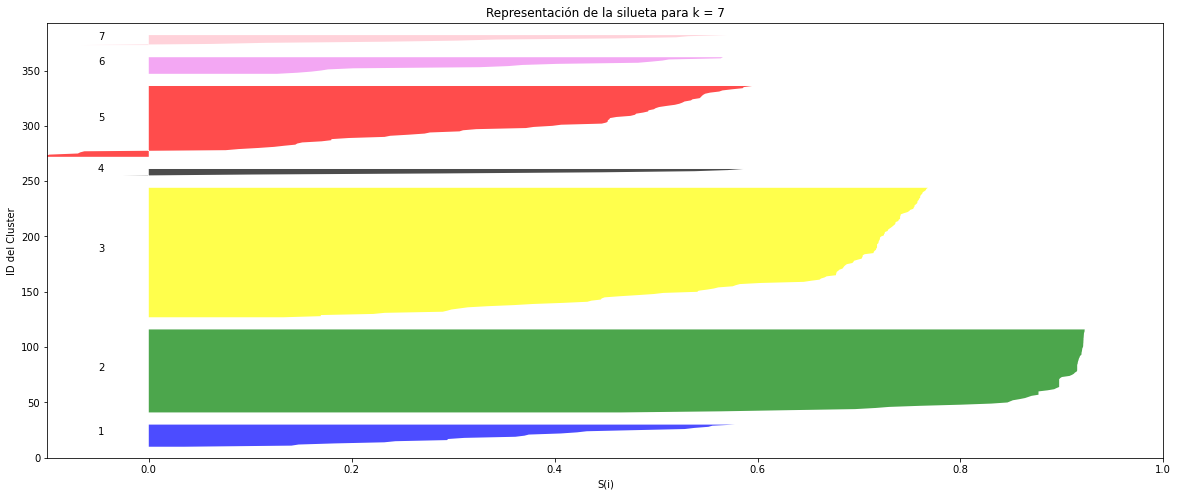

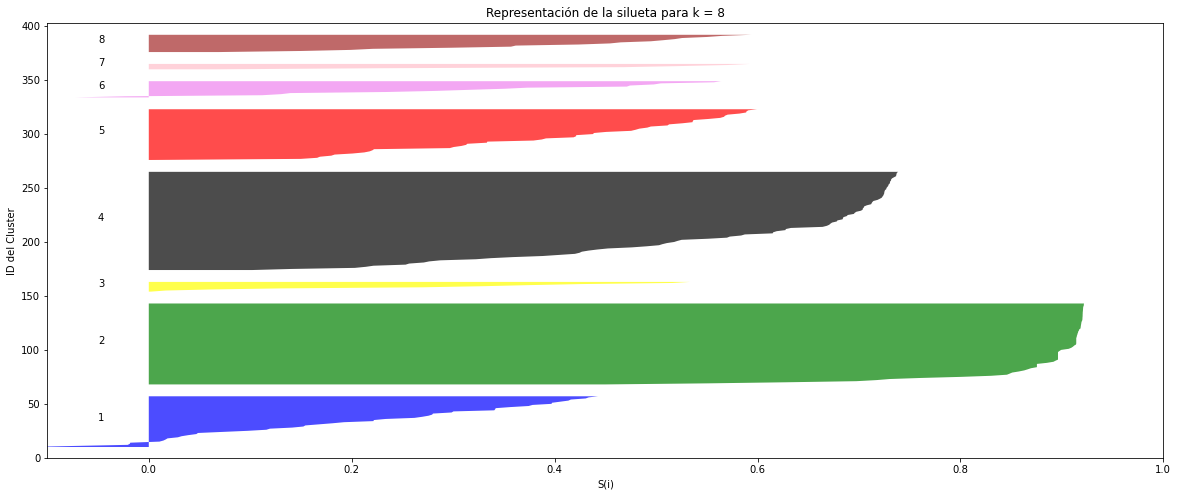

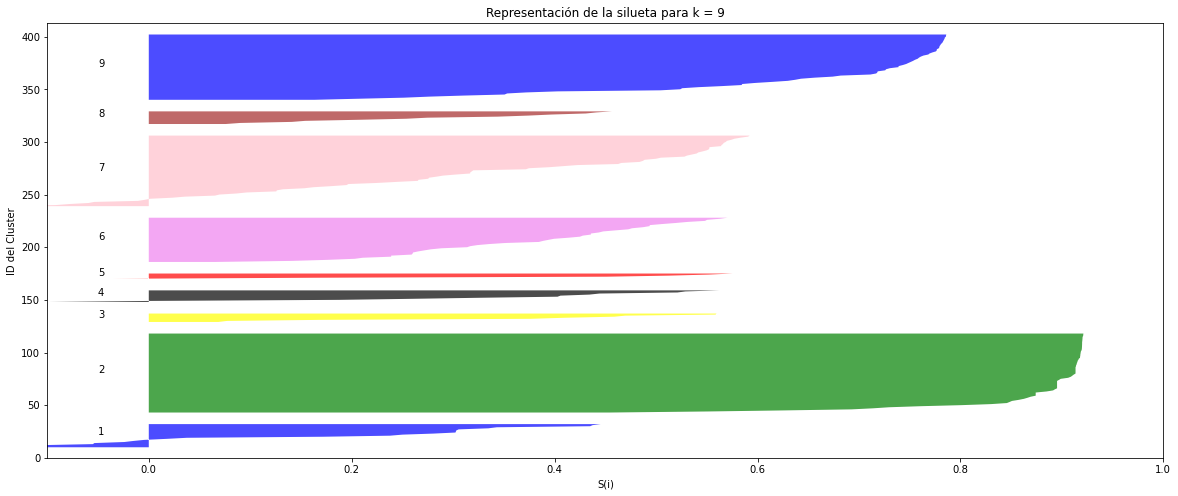

Text(0, 0.5, 'Promedio del Coeficiente de la Silueta')

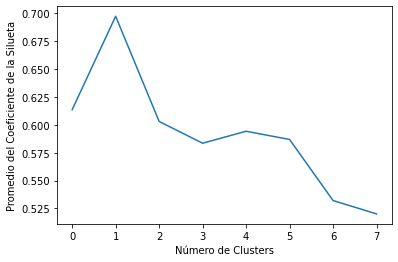

In [80]:

max_k = 10 ## maximo número de clusters que vamos a crear
K = range(1,max_k)
ssw = []
X = data[X_index]
#color_palette = [plt.cm.spectral(float(i)/max_k) for i in K]
color_palette = ["blue","green","yellow","black","red","violet","pink","brown","blue","green"]
#centroid = [sum(X)/len(X) for i in K]
#sst = sum(np.min(cdist(X, centroid, "euclidean"), axis = 1))

silhouette_avgs = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    
    centers = pd.DataFrame(kmeanModel.cluster_centers_)
    labels = kmeanModel.labels_
    
    ssw_k = sum(np.min(cdist(X, kmeanModel.cluster_centers_, "euclidean"), axis = 1))
    ssw.append(ssw_k)
    
    label_color = [color_palette[i] for i in labels]
    
    ##Fabricaremos una silueta para cada cluster
    # Por seguridad, no hacemos silueta si k = 1 o k = len(X)
    if 1<k<len(X):
       ##Crear un subplot de una fila y dos columnas
        fig, axis1 = plt.subplots(1,1)
        fig.set_size_inches(20,8)
    
        #El primer subplot contendrá la silueta, que puede tener valores desde -1 a 1
        #En nuestro caso, ya controlamos que los valores están entre -0.1 y 1
        axis1.set_xlim([-0.1, 1.0])
        #El número de clusters a insertar determinará el tamaño de cada barra
        #El coeficiente (n_clusters+1)*10 será el espacio en blanco que dejaremos 
        #entre siluetas individuales de cada cluster para separarlas.
        axis1.set_ylim([0, len(X)+ (k+1)*10])
    
        silhouette_avg = silhouette_score(X, labels)
        silhouette_avgs.append(silhouette_avg)
        print("* Para k = ",k, " el promedio de la silueta es de :",silhouette_avg)
        sample_silhouette_values = silhouette_samples(X, labels)
        
        y_lower = 10
        for i in range(k):
            #Agregamos la silueta del cluster i-ésimo
            ith_cluster_sv = sample_silhouette_values[labels == i]
            print("   - Para i = ", i+1, " la silueta del cluster vale : ", np.mean(ith_cluster_sv))
            #Ordenamos descendientemente las siluetas del cluster i-ésimo
            ith_cluster_sv.sort()
        
            #Calculamos donde colocar la primera silueta en el eje vertical
            ith_cluster_size = ith_cluster_sv.shape[0]
            y_upper = y_lower + ith_cluster_size
            
            #Elegimos el color del cluster
            color = color_palette[i]
            
            #Pintamos la silueta del cluster i-ésimo
            axis1.fill_betweenx(np.arange(y_lower, y_upper),
                               0, ith_cluster_sv, facecolor = color, alpha = 0.7)
            
            
            #Etiquetamos dicho cluster con el número en el centro
            axis1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i+1))
            
            #Calculamos el nuevo y_lower para el siguiente cluster del gráfico
            y_lower = y_upper + 10 #dejamos vacías 10 posiciones sin muestra
            
        axis1.set_title("Representación de la silueta para k = %s"%str(k))
        axis1.set_xlabel("S(i)")
        axis1.set_ylabel("ID del Cluster")
        
        ##Fin de la representación de la silueta
   
plt.show()
plt.plot([i for i in range(8)],silhouette_avgs)
plt.xlabel("Número de Clusters")
plt.ylabel("Promedio del Coeficiente de la Silueta")
#plt.set_title("Promedio de Coeficiente de la Silueta")
#plt.set_xlabel("Numero de Clusters")
#plt.set_ylabel("Promedio del Coeficiente de la Silueta")

# K-Means

In [99]:
model = KMeans(n_clusters=3)
model.fit(data[X_index])

KMeans(n_clusters=3)

In [100]:
data["cluster"] = model.labels_
data.head()

,BARRIO,ACCIDENTES,MUERTO,HERIDO,SOLO_DANOS,cluster
0,aguas frias,0.011449,0.000000,0.045774,0.022944,1
1,aldea pablo vi,0.009591,0.500000,0.040617,0.023556,0
2,alejandria,0.087922,0.500000,0.071926,0.120291,0
3,alejandro echavarria,0.154676,0.500000,0.269274,0.082699,0
4,alfonso lopez,0.205397,0.583333,0.332080,0.119722,0


Interpretación final, para ello primero llevamos los datos a su escala original

In [101]:
for index in X_index:
    x = data[index].values
    min_max_scaler = min_max_scalers[index]
    x_scaled = min_max_scaler.inverse_transform(x.reshape(-1,1))
    data[index] = x_scaled

    
data.head()

,BARRIO,ACCIDENTES,MUERTO,HERIDO,SOLO_DANOS,cluster
0,aguas frias,1.959184,0.000000,1.690476,1.136364,1
1,aldea pablo vi,1.803571,1.000000,1.500000,1.166667,0
2,alejandria,8.366197,1.000000,2.656250,5.957746,0
3,alejandro echavarria,13.958904,1.000000,9.944444,4.095890,0
4,alfonso lopez,18.208333,1.166667,12.263889,5.929577,0


In [102]:
data.groupby("cluster").mean()

,ACCIDENTES,MUERTO,HERIDO,SOLO_DANOS
cluster,,,,
0,9.415932,1.061539,5.695242,4.036894
1,2.830609,0.000000,1.964569,1.574200
2,46.059849,1.177651,21.745066,24.189341


Con base en los resultados promedios de los clusters, podemos decir que asignaremos el nombre del cluster por el peligro y alta accidentalidad de los barrios:

- 0: Peligro Moderado
- 1: Peligro Bajo
- 2: Peligro Alto

In [103]:
data.to_excel("clustering.xlsx")